In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Lesson 5: Neural Nets from scratch (alternative title: why you should always use frameworks)

In this mini-project I'll be tackling the quintissential Kaggle competition, *Titanic - Machine Learning from Disaster*. 

In [3]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)
        
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

The first thing we'll need to do is take a look at the dataset. Since we're building our own network from scratch we will need to be extra sure that our data is in good shape. Frameworks such as fastai often have built-in functionality to clean up and normalize data, but in this case we will do that all ourselves. Even while using a framework it's always a good idea to get to know your data before building a model.

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Generally when we're looking at a dataset, there are a few main issues we should keep our eye out for:
* Missing Data
* Non-numeric data (all data must be numeric!)
* Wacky distributions (models, especially linear models like we'll be building, can struggle with long-tail distributions
* Non-normalized values (we'd like to see values range between 0 and 1, or -1 and 1. In this notebook we'll normalize everything to be between 0 and 1).

Before we do any of that, we should read through the descriptions of each column to make sure we have a good handle on the contents of the dataset.

The columns are defined as follows:
* PassengerId: unique integer id for each passenger
* Survived: 0 = passenger died, 1 = passenger survived
* Pclass: 3 classes of tickets numbered 1-3, 1 = Upper, 2 = Middle, 3 = Lower
* Name: Passenger's full name
* Sex: 'male' or 'female'
* Age: for some reason this is listed as fractional if < 1. also if the age is estimated it's given as XX.5 instead of XX.0
* SibSp: # of siblings and spouses on board
* Parch: # of parents and children on board
* Ticket: Ticket number (seems to be an int but sometimes a string code appears in front)
* Fare: Price of the passenger's ticket
* Cabin: Room number
* Embarked: Port embarked from (C = Cherbourg, Q = Queenstown, S = Southampton)

Any column that allows us to differentiate groups of individuals could be useful for our model. These columns are:
* Surived (This is what we are trying to predict!)
* Pclass
* Sex
* Age
* Sibsp
* Parch
* Fare
* Embarked

It's worth noting that we could use the *Name* column in order to group passengers by last name. However, we get a similar and more accurate insight into family connections via the *Sibsp* and *Parch* columns, so this feels unnessecary. 

We can now go through them to make sure each column is cleaned and ready to be trained on.

**Missing Data**

First let's look for missing data. In datasets this usually shows up as `NaN` but it's possible that your dataset could also portray it a different way.

In [6]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that there are a few columns that have missing values. The technique taught in lecture to deal with this is to replace the missing values with the column mode. It is important to try to fill missing data when possible rather than delete rows/columns, as this removes valuable information from the dataset -- it's especially important with smaller datasets like the one we have now.

Let's replace the missing values with the column modes:

In [7]:
modes = df.mode().iloc[0]
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Great! Now we've dealt with all the missing values. Let's check over each column:

The *Survived* field is already encoded as a 0 or 1, so there's nothing we need to change.

The *Pclass* field is currently encoded as an integer between 1 and 3. Since this is categorical data, it is probably more useful to encode this as 3 seperate booleans instead of an interger value. We can use the *pd.get_dummies()* method to create 3 new columns for each of the 3 classes: *Pclass_1, Pclass_2, and Pclass3*.

In [8]:
df = pd.get_dummies(df, columns=['Pclass'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Pclass_1', 'Pclass_2',
       'Pclass_3'],
      dtype='object')

In [9]:
df[['Pclass_1', 'Pclass_2', 'Pclass_3']].head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


The *Sex* field currently contains the values 'male' and 'female'. We can just create a simple boolean column 'IsMale' to numeralize this field.

In [10]:
df = pd.get_dummies(df, columns=['Sex'])
df[['Sex_male', 'Sex_female']].head()

,Sex_male,Sex_female
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0


<AxesSubplot:>

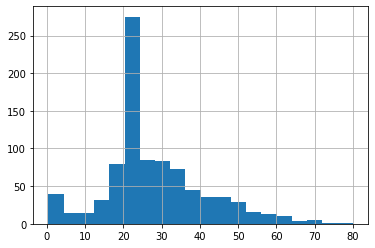

In [11]:
df['Age'].hist(bins=20)

The distribution is not normal, but it is kind of sort of *normal-ish*. I am going to simply normalize these values to be between 0 and 1 with age == min_age -> 0 and age == max_age -> 1, but YMMV. We'll learn more about advanced feature engineering techniques in future lectures.

In [12]:
min_age = df['Age'].min()
max_age = df['Age'].max()

df['NormAge'] = df['Age'].apply(lambda a: (a - min_age) / (max_age - min_age))
df['NormAge'].head()

0    0.271174
1    0.472229
2    0.321438
3    0.434531
4    0.434531
Name: NormAge, dtype: float64

Now let's consider *Sibsp* and *Parch*.

<AxesSubplot:>

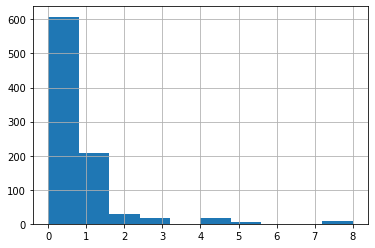

In [13]:
df['SibSp'].hist()

<AxesSubplot:>

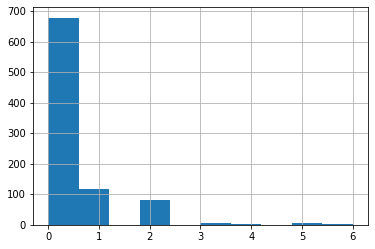

In [14]:
df['Parch'].hist()

We can also normalize these columns to be between 0 and 1 like we did with *Age*.

In [15]:
min_sibsp = 0
max_sibsp = df['SibSp'].max()
df['NormSibSp'] = df['SibSp'].apply(lambda a: (a - min_sibsp) / (max_sibsp - min_sibsp))

min_parch = 0
max_parch = df['Parch'].max()
df['NormParch'] = df['Parch'].apply(lambda a: (a - min_parch) / (max_parch - min_parch))

df[['NormParch', 'NormSibSp']]

,NormParch,NormSibSp
0,0.000000,0.125
1,0.000000,0.125
2,0.000000,0.000
3,0.000000,0.125
4,0.000000,0.000
...,...,...
886,0.000000,0.000
887,0.000000,0.000
888,0.333333,0.125
889,0.000000,0.000


The strategy we used in lecture for the *Fare* column was to apply a log function to it in order to help normalize its long-tail distribution.

<AxesSubplot:>

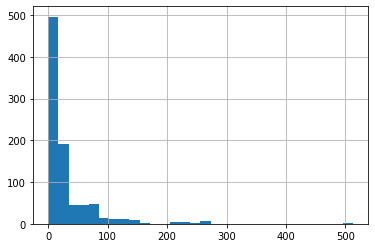

In [16]:
df['Fare'].hist(bins=30)

In [17]:
df['Fare'].min()

0.0

Since, log(0) is infinity, we can simply add 1 to every value and then apply the log function

<AxesSubplot:>

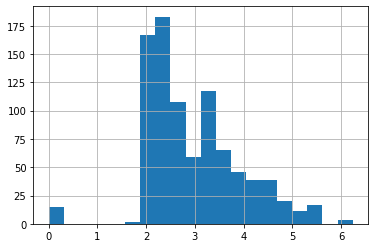

In [18]:
df['LogFare'] = np.log(df['Fare'] + 1)
df['LogFare'].hist(bins=20)

This looks better! Now we can normalize this column to be between 0 and 1, while keeping our distribution intact.

In [19]:
min_log_fare = df['LogFare'].min()
max_log_fare = df['LogFare'].max()

df['NormLogFare'] = df['LogFare'].apply(lambda a: (a - min_log_fare) / (max_log_fare - min_log_fare))
df['NormLogFare'].head()

0    0.338125
1    0.685892
2    0.350727
3    0.639463
4    0.352955
Name: NormLogFare, dtype: float64

Lastly, we can use *get_dummies* to create binary columns for each of the three possible embarkments.

In [20]:
df = pd.get_dummies(df, columns=['Embarked'])
df[['Embarked_C', 'Embarked_Q', 'Embarked_S']].head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


Now that we've finished cleaning, selecting, and normalizing our features, we can move on to building a linear model. Let's make sure we only include the columns we care about, those being:

In [21]:
inputs = df[['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Sex_female', 'NormAge', 'NormSibSp', 'NormParch', 'NormLogFare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
inputs.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_male,Sex_female,NormAge,NormSibSp,NormParch,NormLogFare,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1,1,0,0.271174,0.125,0.0,0.338125,0,0,1
1,1,0,0,0,1,0.472229,0.125,0.0,0.685892,1,0,0
2,0,0,1,0,1,0.321438,0.000,0.0,0.350727,0,0,1
3,1,0,0,0,1,0.434531,0.125,0.0,0.639463,0,0,1
4,0,0,1,1,0,0.434531,0.000,0.0,0.352955,0,0,1


Since we're building a simple linear model, we just need a coeffecient to multiply each value by. We can initialize a tensor to random values.

In [22]:
import torch
torch.manual_seed(98)
num_features = inputs.shape[1]



coeffs = torch.rand(num_features) - 0.5
coeffs.requires_grad_()
coeffs

tensor([-0.0396, -0.3989, -0.2996, -0.4041, -0.3867, -0.1910,  0.3292,  0.4408, -0.0442,  0.4288, -0.0590, -0.3155], requires_grad=True)

Then, in order to get a prediction from this model, we'd simply compute:

In [23]:
input_tensor = torch.tensor(inputs.values, dtype=torch.float)

preds = input_tensor@coeffs
preds[:10]

tensor([-1.0448, -0.0768, -1.0787, -0.8119, -1.1178, -0.8352, -0.9159, -0.8480, -0.9363, -0.3725], grad_fn=<SliceBackward0>)

We'd love for these predictions to be between 0 and 1, since we are ultimately trying to predict whether a passenger perishes (0) or survives (1).  There are several methods we could use to enforce this constraint, one of which is the *sigmoid* function.

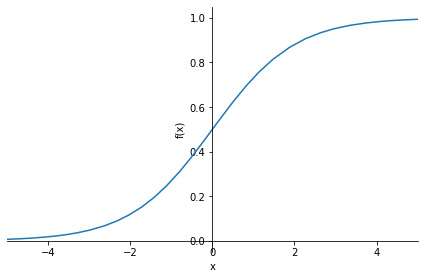

In [24]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5))

If we apply this function to the set of our predictions the will all be between 0 and 1!

In [25]:
torch.sigmoid(preds)[:10]

tensor([0.2602, 0.4808, 0.2537, 0.3075, 0.2464, 0.3025, 0.2858, 0.2999, 0.2816, 0.4079], grad_fn=<SliceBackward0>)

Now we'd like to implement a way to perform gradient descent on our coefficient values, in order to improve our predictions. Just like we did in the project for lesson 3, we'll need to choose a way to calculate loss. Mean Absolute Error seems like a fine choice, so we'll use that loss function again just as we did last time.

In [26]:
def get_mae_loss(preds, actuals):
    return torch.abs(preds - actuals).mean()

actuals = torch.tensor(df['Survived'].values, dtype=torch.float)

loss = get_mae_loss(preds[:10], actuals[:10])
loss

tensor(1.3038, grad_fn=<MeanBackward0>)

A function to get predictions and apply the sigmoid function would also be useful: 

In [27]:
def get_preds(inputs, coeffs):
    return torch.sigmoid(inputs@coeffs)

get_preds(input_tensor, coeffs)[:10]

tensor([0.2602, 0.4808, 0.2537, 0.3075, 0.2464, 0.3025, 0.2858, 0.2999, 0.2816, 0.4079], grad_fn=<SliceBackward0>)

Now we just need to implement a way to perform gradient descent! As a refresher, we need to calculate the loss, propogate the loss to our coefficients, and then calculate the gradient for each coefficient. We want to move each coefficient a small amount in the opposite direction of the sign of the loss.

In [28]:
def gradient_descent(num_epochs, coeffs, inputs, actuals, learning_rate=0.01, print_every=None):
    if print_every is None:
        print_every = num_epochs // 10
    for i in range(num_epochs):
        preds = get_preds(inputs, coeffs)
        loss = get_mae_loss(preds, actuals)
        loss.backward()
        with torch.no_grad():
            coeffs.sub_(coeffs.grad * learning_rate)
            coeffs.grad.zero_()
        if i % print_every == 0:
            print(f"epoch {i} loss: {loss:.3f}")

One last thing before we train our model, we need to split our data into a training and validation set! We do this to make sure our model can generalize by testing it on the validation set after training.

In [29]:
from fastai.data.transforms import RandomSplitter

train_split, val_split = RandomSplitter(seed=98)(df)

train_inputs, val_inputs = input_tensor[train_split], input_tensor[val_split]
train_actuals, val_actuals  = actuals[train_split], actuals[val_split]

len(train_inputs),len(val_inputs)

(713, 178)

Now we're finally ready to train the model using gradient descent:

In [30]:
coeffs = torch.rand(num_features) - 0.5
coeffs.requires_grad_()

gradient_descent(50, coeffs, train_inputs, train_actuals, learning_rate=0.1)

epoch 0 loss: 0.460
epoch 5 loss: 0.449
epoch 10 loss: 0.438
epoch 15 loss: 0.429
epoch 20 loss: 0.419
epoch 25 loss: 0.411
epoch 30 loss: 0.402
epoch 35 loss: 0.395
epoch 40 loss: 0.388
epoch 45 loss: 0.381


We see our loss steadily go down, which is great! Now we can see how accurately we predict against the validation set. We want to make sure to use the accuracy metric that our model will be judged on, which is a binary classifcation rather than MSE.

In [31]:
def get_accuracy(coeffs):
    preds = get_preds(val_inputs, coeffs)

    accurate_predictions = val_actuals.bool() == (preds > 0.5)

    return accurate_predictions.float().mean()

get_accuracy(coeffs)

tensor(0.7640)

This accuracy is ok but not great, but perhaps we can improve it by tuning some of our hyperparameters and trying again. (We should not tune against our validation accuracy of course, as that would defeat the purpose!)

Let's try a larger learning rate while decreasing the nunber of epochs.

In [32]:
coeffs = torch.rand(num_features) - 0.5
coeffs.requires_grad_()

gradient_descent(40, coeffs, train_inputs, train_actuals, learning_rate=70)

epoch 0 loss: 0.445
epoch 4 loss: 0.187
epoch 8 loss: 0.184
epoch 12 loss: 0.183
epoch 16 loss: 0.182
epoch 20 loss: 0.181
epoch 24 loss: 0.181
epoch 28 loss: 0.181
epoch 32 loss: 0.181
epoch 36 loss: 0.180


This loss is better than before, now let's run it on the validation set again.

In [33]:
get_accuracy(coeffs)

tensor(0.7697)

This is considerably worse than the results we got in class, but given the dataset is small this could also be something to do with using a different random seed. For comparison's sake we can try using the split we saw in class to get a better comparison of performance.

In [34]:

train_split, val_split = RandomSplitter(seed=42)(df)

train_inputs, val_inputs = input_tensor[train_split], input_tensor[val_split]
train_actuals, val_actuals  = actuals[train_split], actuals[val_split]

coeffs = torch.rand(num_features) - 0.5
coeffs.requires_grad_()

gradient_descent(40, coeffs, train_inputs, train_actuals, learning_rate=70)
get_accuracy(coeffs)

epoch 0 loss: 0.501
epoch 4 loss: 0.202
epoch 8 loss: 0.199
epoch 12 loss: 0.197
epoch 16 loss: 0.196
epoch 20 loss: 0.196
epoch 24 loss: 0.195
epoch 28 loss: 0.195
epoch 32 loss: 0.195
epoch 36 loss: 0.195


tensor(0.8258)

Now, despite the tweaks we've made on the approach we used in class, our accuracy is actually the same! Splitting our data differently and getting a higher accuracy means nothing in terms of our model's accuracy of course, but it's nice to see similar performance to the model from lecture when holding the dataset split constant.

